In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = './pg_ressults/policy_gradient_Adam_0.0001_0.6177143132365915.json'


def scatter_model_used(model_info, num_models, num_trials):
    counter = 0
    used_list = []
    
    for _ in range(num_models):
        used_list.append(np.full(num_trials, -10))
    
    for key, value in model_info.items():

        for used in value['used_index']:
            used_list[counter][used] = counter

        counter += 1
        
    counter_list = range(num_trials)
    
    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0, int(round(num_models * 1.05)))
    for i in range(num_models):
        plt.scatter(counter_list, used_list[i])
    plt.show()
    
def plot_loss(policy_list, title):
    plt.figure(figsize=(16, 10))
    #plt.ylim(0,1)
    plt.xlabel('Step', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(title, fontsize=30)

    plt.plot(policy_list,'m' ,linewidth=3, label='Loss')
    plt.legend(loc='best', fontsize=15)
    plt.show()

#Reduce the list so graph get more general and easyer to read
def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses
    
def score_graph(scores, iou_scores, means, model_info, batch_size, list_length, num_models):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    iou_scores_reduced, _ = generalize_list(iou_scores, batch_size)
    score_reduced, x_akses = generalize_list(scores, batch_size)
    mean_reduced, _ = generalize_list(means, batch_size)
    
    
    print(f' Avg score pr model: {model_score_avg}')
    
    avg = np.array([model_score_avg for i in range(list_length)])
    avg_explore = np.array([0.519 for i in range(list_length)]) # 0.5186551321699284
    #avg_iou = np.array([0.0185 for i in range(list_length)]) #0.0185 0.13364625770486935
    avg_iou = np.array([0.101 for i in range(list_length)]) #0.10119017522614594
    
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average Lower Bound')
    plt.plot(avg_explore, 'm--', label='Average score')
    plt.plot(avg_iou, 'y--', label='Average IoU')
    plt.plot(x_akses, mean_reduced,'g' ,linewidth=3, label='Mean')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='pixel score')
    plt.plot(x_akses, iou_scores_reduced,'c' ,linewidth=3, label='iou score')
    plt.legend(loc='best', fontsize=15)
    plt.show()

In [3]:
with open(file_path) as reader:
    model_info = json.load(reader)



In [4]:
print('------------------------ MODEL INFO START ------------------------')
print(f'Policy lr: {model_info["policy_lr"]}, Policy clip: {model_info["policy_clip"]}')
print(f'Value lr: {model_info["value_lr"]}, Value clip: {"value_clip"}')
print(f'Reward ekspontential: {model_info["reward_exponential"]}, Reward mulitiplikation: {model_info["reward_multi"]}, batch size: {model_info["batch_size"]}, box size: {model_info["box_size"]}, gamma: {model_info["gamma"]}')


------------------------ MODEL INFO START ------------------------
Policy lr: 0.0001, Policy clip: 3
Value lr: 0.001, Value clip: value_clip
Reward ekspontential: 10, Reward mulitiplikation: 10, batch size: 10, box size: 10, gamma: 1


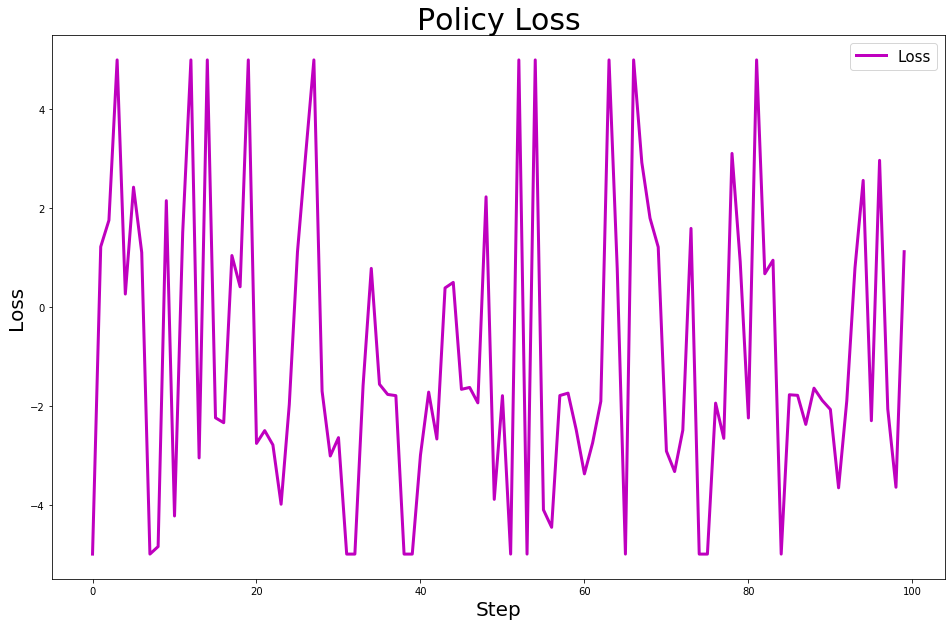

In [5]:
plot_loss(model_info['policy_loss'], 'Policy Loss')

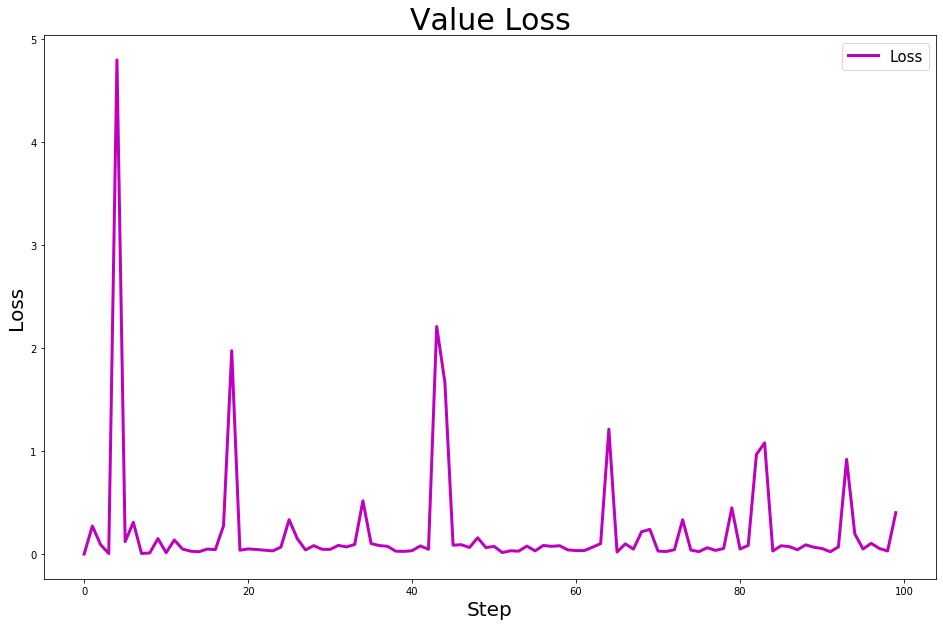

In [6]:
plot_loss(model_info['value_loss'], 'Value Loss')

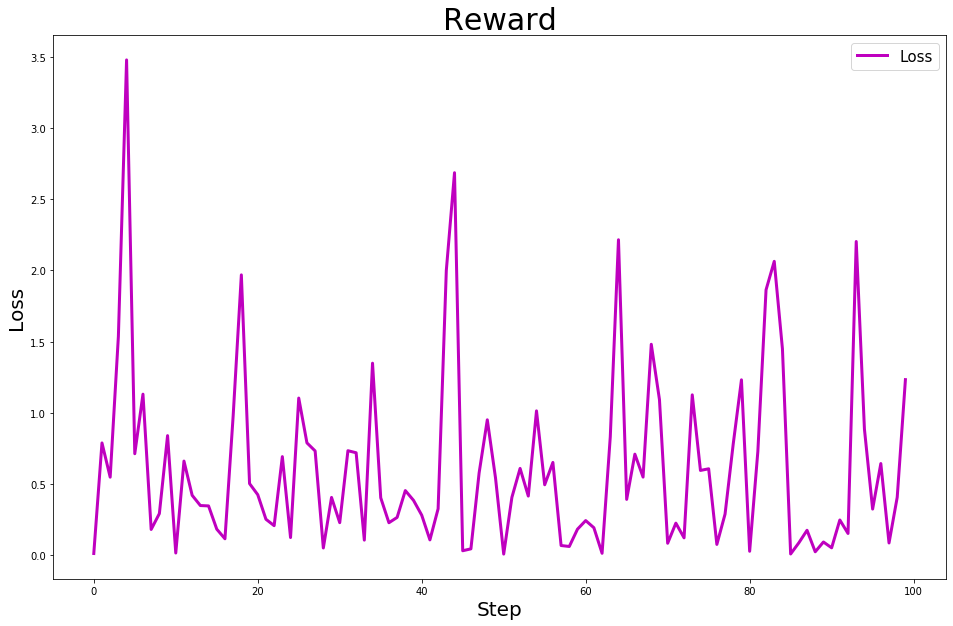

In [7]:
plot_loss(model_info['reward_list'], 'Reward')

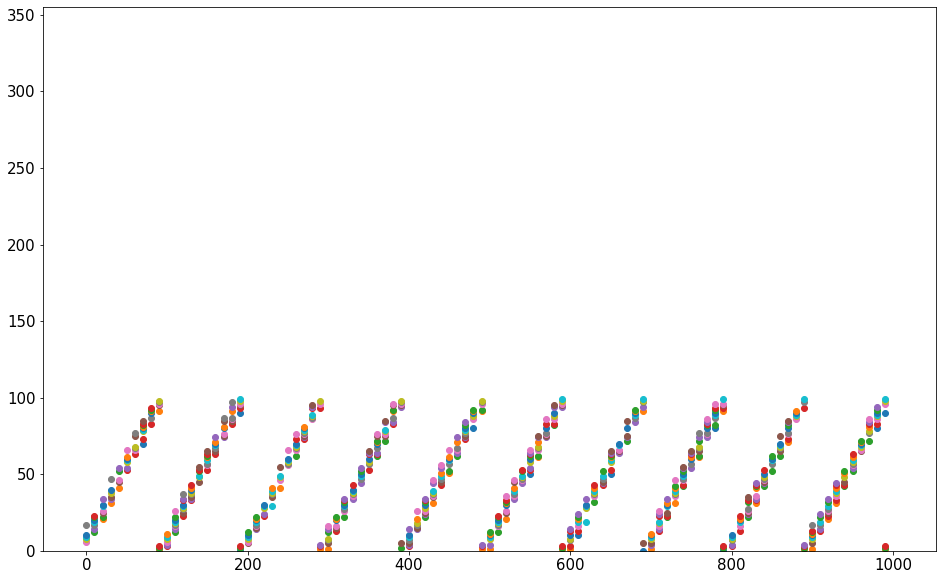

In [8]:
scatter_model_used(model_info['model_info'], model_info['num_models'], model_info['num_trials'])

 Avg score pr model: 0.13999317282192075


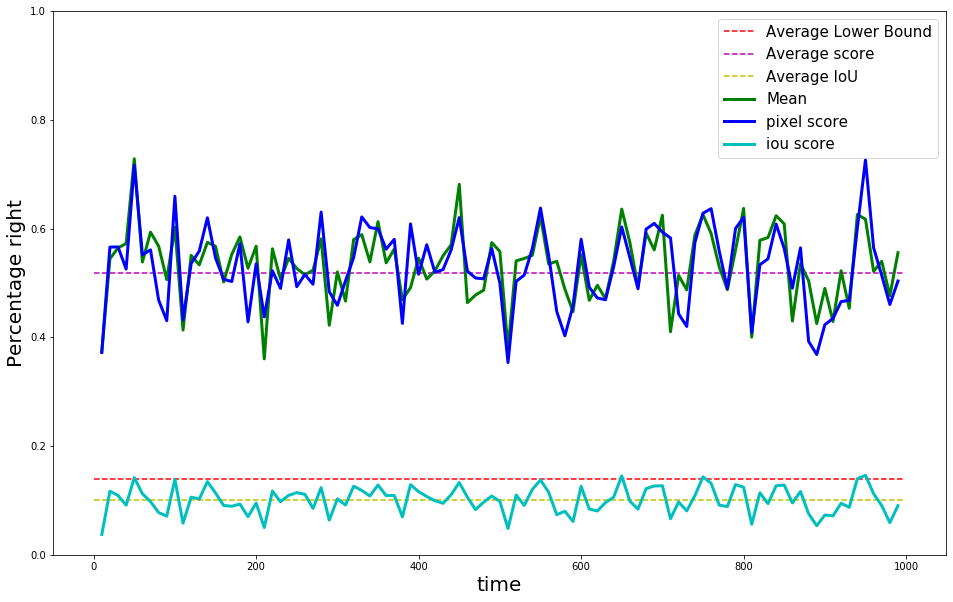

In [9]:
score_graph(model_info['pixel_scores'], model_info['iou_scores'], model_info['mean_values'], model_info['model_info'], batch_size=model_info['batch_size'], list_length=model_info['num_trials'], num_models=model_info['num_models'])

In [10]:
for key in model_info.keys():
    print(key)

policy_lr
value_lr
policy_clip
value_clip
reward_exponential
reward_multi
batch_size
box_size
gamma
reward_list
policy_loss
value_loss
optimizer
num_models
num_trials
iou_scores
pixel_scores
mean_values
std_values
model_info
